## 1. 필요한 라이브러리 임포트

In [1]:
# 주요 패키지
import numpy as np
import pandas as pd
import os 
from pathlib import Path
from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

#
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix

# 직접 개발한 패키지
from utils.config import CONFIG
from utils.visualize import visualize_data
from modules.input import TimeSeriesDownSampler

from training.model_training import create_lstm_autoencoder
from training.data_preprocessing import create_sequences
from lstmae import LSTMAutoencoder

# 딥러닝 프레임워크
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from enum import Enum
class ModelType(Enum):
    VIB = 1
    VOLT = 2
    TEMP = 3

feature_types = {
    ModelType.VIB : 'vib',
    ModelType.VOLT : 'volt',
    ModelType.TEMP : 'temp'
}

2024-12-16 14:02:38.999351: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 14:02:39.021572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-16 14:02:39.355818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# 새 모델을 만들 때마다 이 부분을 수정해주세요
model_type = ModelType.VOLT
lookback = 5

In [3]:
scaler_name = 'scaler_' + feature_types[model_type] + '_' + str(lookback)
model_name = feature_types[model_type] + '_' + str(lookback)

In [ ]:
model_path = Path('../models') / (model_name + '.pth')
scaler_path = Path('../models') / (scaler_name + '.joblib')
data_path = Path('../datas')
normal_data_path = Path('../datas/normal') / (feature_types[model_type])
abnormal_data_path = Path('../datas/abnormal') / (feature_types[model_type])
model_dim = 3 if model_type == ModelType.VIB else 1

In [5]:
print(model_path)
print(scaler_path)
print(normal_data_path)
print(abnormal_data_path)

../models/volt_5.pth
../models/scaler_volt_5.joblib
../datas/normal/volt
../datas/abnormal/volt


## 2. 데이터 로드 및 전처리 함수 정의

In [6]:
# 1. 세션 파일 로딩
def load_session(file_path):
    """
    단일 세션 데이터를 로드하는 함수
    file_path 경로의 데이터를 로드하여 가속도 데이터만을 골라
    데이터프레임으로 반환
    """
    df = pd.read_csv(file_path)
    # 필요한 데이터의 칼럼만 선택
    columns = []
    if model_type == ModelType.VIB:
        columns = ['accel_x', 'accel_y', 'accel_z']
    elif model_type == ModelType.VOLT:
        columns = ['voltage']
    elif model_type == ModelType.TEMP:
        columns = ['temperature']
    return df[columns].values

In [7]:
# 2. 세션 하나(data)로 시퀀스들 생성
def create_sequences(df, sequence_length=5, step_size=3):
    """
    시계열 데이터를 시퀀스로 변환하는 함수
    데이터를 길이 sequence_length의 시퀀스들로 step size만큼 이동하며 생성
    생성된 시퀀스들의 배열을 반환
    """
    sequences = []
    for i in range(0, len(df) - sequence_length + 1, step_size):
        sequence = df[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

In [8]:
# 3. 정상 시퀀스 생성
def prepare_normal_data(normal_data_dir):
    """
    각 세션별로 균등하게 분할하여 데이터셋 준비
    위 함수들을 이용해 데이터셋 준비
    세션-시퀀스 쌍 딕셔너리 배열을 만든 다음
    각 세션 별로 시퀀스들을 70:20:10으로 분할
    
    train sequence에 대해 스케일러 학습시키고
    이 스케일러로 validation seq, test seq도 적용용
    """
    data_dir = Path(normal_data_dir)
    
    # 각 세션별로 시퀀스 생성
    session_sequences = []
    for file_path in data_dir.glob('*.csv'):
        print(file_path)
        session_data = load_session(file_path)
        sequences = create_sequences(session_data)
        session_sequences.append({
            'file_name': file_path.name,
            'sequences': sequences
        })
    
    # 각 세션별로 70:20:10 분할
    train_sequences = []
    val_sequences = []
    test_sequences = []
    
    for session in session_sequences:
        sequences = session['sequences']
        n_sequences = len(sequences)
        
        # 인덱스 무작위 섞기
        indices = np.random.permutation(n_sequences)
        
        # 비율에 따라 분할
        n_train = int(n_sequences * 0.7)
        n_val = int(n_sequences * 0.2)
        
        train_idx = indices[:n_train]
        val_idx = indices[n_train:n_train + n_val]
        test_idx = indices[n_train + n_val:]
        
        train_sequences.append(sequences[train_idx])
        val_sequences.append(sequences[val_idx])
        test_sequences.append(sequences[test_idx])
        
        print(f"Session {session['file_name']}: {len(sequences)} sequences")
        print(f"  - Train: {len(train_idx)}")
        print(f"  - Val: {len(val_idx)}")
        print(f"  - Test: {len(test_idx)}")
    
    # 각 세트 내에서 세션 데이터 합치기
    train_sequences = np.concatenate(train_sequences)
    val_sequences = np.concatenate(val_sequences)
    test_sequences = np.concatenate(test_sequences)
    
    # 스케일러 학습 (훈련 데이터만 사용)
    scaler = StandardScaler()
    #scaler = MinMaxScaler()
    train_sequences_2d = train_sequences.reshape(-1, train_sequences.shape[-1])
    scaler.fit(train_sequences_2d)
    
    # 스케일러 저장
    dump(scaler, scaler_path)
    print(f"\nScaler saved to {scaler_path}")
    
    def scale_sequences(sequences):
        original_shape = sequences.shape
        sequences_2d = sequences.reshape(-1, sequences.shape[-1])
        scaled_2d = scaler.transform(sequences_2d)
        return scaled_2d.reshape(original_shape)
    
    # 모든 데이터 스케일링
    train_sequences_scaled = scale_sequences(train_sequences)
    val_sequences_scaled = scale_sequences(val_sequences)
    test_sequences_scaled = scale_sequences(test_sequences)
    
    return {
        'train': train_sequences_scaled,
        'val': val_sequences_scaled,
        'test_normal': test_sequences_scaled,
        'scaler': scaler
    }

In [9]:
# 4. 스케일러 로딩
def load_scaler(models_dir='models'):
    """저장된 스케일러를 불러오는 함수"""
    if not scaler_path.exists():
        raise FileNotFoundError(f"Scaler file not found at {scaler_path}")
    return load(scaler_path)

In [10]:
# 5. 테스트 시퀀스 준비
def prepare_test_data(abnormal_data_dir):
    """저장된 스케일러를 사용하여 테스트 데이터를 준비하는 함수"""
    data_dir = Path(abnormal_data_dir)
    # 저장된 스케일러 로드
    scaler = load_scaler(scaler_path)
    
    # 이상치 데이터 로드
    abnormal_sequences = []
    for file_path in data_dir.glob('*.csv'):
        print(file_path)
        session_data = load_session(file_path)
        sequences = create_sequences(session_data)
        abnormal_sequences.extend(sequences)
    abnormal_sequences = np.array(abnormal_sequences)
    
    # 이상치 데이터 스케일링
    def scale_sequences(sequences):
        original_shape = sequences.shape
        sequences_2d = sequences.reshape(-1, sequences.shape[-1])
        scaled_2d = scaler.transform(sequences_2d)
        return scaled_2d.reshape(original_shape)
    
    abnormal_sequences_scaled = scale_sequences(abnormal_sequences)
    
    return {'abnormal': abnormal_sequences_scaled}

In [11]:
# 6. 데이터셋 클래스
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = torch.FloatTensor(sequences)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx]

## 3. 모델 클래스 정의(lstmae.py에서 했음)

## 4. 모델 학습 함수 정의

In [12]:
def train_model(model, train_loader, val_loader, 
                n_epochs=100, learning_rate=1e-3, 
                device='cuda' if torch.cuda.is_available() else 'cpu',
                patience=10, model_save_path=model_path):
    """
    LSTM Autoencoder 모델 훈련 함수
    
    Args:
        model: LSTM Autoencoder 모델
        train_loader: 훈련 데이터 로더
        val_loader: 검증 데이터 로더
        n_epochs: 전체 에포크 수
        learning_rate: 학습률
        device: 학습 디바이스 (CPU/GPU)
        patience: Early stopping patience
        model_save_path: 모델 저장 경로
    """
    # 모델을 지정된 디바이스로 이동
    model = model.to(device)
    
    # 손실 함수와 옵티마이저 정의
    criterion = nn.MSELoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Early stopping 관련 변수들
    best_val_loss = float('inf')
    patience_counter = 0
    early_stop = False
    
    # 훈련 과정 모니터링을 위한 리스트
    train_losses = []
    val_losses = []
    
    # 모델 저장 경로 설정
    model_save_path = Path(model_save_path)
    model_save_path.parent.mkdir(exist_ok=True)
    
    for epoch in range(n_epochs):
        # 훈련 모드
        model.train()
        train_loss = 0
        train_batches = 0
        
        # 훈련 루프
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}'):
            batch = batch.to(device)
            
            # 순전파
            output = model(batch)
            loss = criterion(output, batch)
            
            # 역전파 및 옵티마이저 스텝
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
        
        # 에포크당 평균 훈련 손실 계산
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # 검증 모드
        model.eval()
        val_loss = 0
        val_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch)
                loss = criterion(output, batch)
                val_loss += loss.item()
                val_batches += 1
        
        # 에포크당 평균 검증 손실 계산
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        # 현재 상태 출력
        print(f'Epoch [{epoch+1}/{n_epochs}]')
        print(f'  Training Loss: {avg_train_loss:.6f}')
        print(f'  Validation Loss: {avg_val_loss:.6f}')
        
        # Early stopping 체크
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # 최상의 모델 저장
            torch.save(model.state_dict(), model_save_path)
            print(f'  Model saved to {model_save_path}')
        else:
            patience_counter += 1
            print(f'  EarlyStopping counter: {patience_counter} out of {patience}')
            
        if patience_counter >= patience:
            print('Early stopping triggered')
            early_stop = True
            break
    
    # 학습 과정 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses

def load_trained_model(model, model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    저장된 모델 가중치를 로드하는 함수
    """
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

In [13]:
def evaluate_model(model, test_loader, test_labels, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    모델 평가 및 다양한 메트릭 계산/시각화
    
    Args:
        model: 학습된 LSTM Autoencoder 모델
        test_loader: 테스트 데이터 로더
        test_labels: 테스트 데이터의 실제 레이블 (0: 정상, 1: 이상)
        device: 평가 수행할 디바이스
    """
    model.eval()
    reconstruction_errors = []
    
    # 재구성 오차 계산
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            # 각 샘플의 재구성 오차 계산
            errors = torch.mean((batch - output) ** 2, dim=(1, 2))
            
            # MinMaxScaler에 맞는 상대 오차로 변경
            #relative_error = torch.abs(batch - output) / (torch.abs(batch) + 1e-6)
            #errors = torch.mean(relative_error, dim=(1, 2))
            reconstruction_errors.extend(errors.cpu().numpy())
    
    reconstruction_errors = np.array(reconstruction_errors)
    
    # 1. 재구성 오차 분포 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(reconstruction_errors[test_labels == 0], bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(reconstruction_errors[test_labels == 1], bins=50, alpha=0.5, label='Anomaly', density=True)
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Errors')
    plt.legend()
    plt.show()
    
    # 2. ROC 커브
    fpr, tpr, roc_thresholds = roc_curve(test_labels, reconstruction_errors)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # 3. Precision-Recall 커브
    precision, recall, pr_thresholds = precision_recall_curve(test_labels, reconstruction_errors)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # 4. 최적 임계값 찾기
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_threshold_idx = np.argmax(f1_scores)
    optimal_threshold = pr_thresholds[optimal_threshold_idx]
    
    # 5. 혼동 행렬
    predictions = (reconstruction_errors >= optimal_threshold).astype(int)
    cm = confusion_matrix(test_labels, predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (threshold = {optimal_threshold:.4f})')
    plt.show()
    
    # 6. 성능 지표 계산
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision_score = tp / (tp + fp)
    recall_score = tp / (tp + fn)
    f1 = 2 * (precision_score * recall_score) / (precision_score + recall_score)
    
    print("\nPerformance Metrics:")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision_score:.4f}")
    print(f"Recall: {recall_score:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    
    return {
        'reconstruction_errors': reconstruction_errors,
        'optimal_threshold': optimal_threshold,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm,
        'f1_score': f1
    }

## 5. 학습 및 테스트 진행

In [14]:
# 1. 데이터 준비
# 정상 데이터 준비 (훈련, 검증, 테스트용 정상 데이터)
normal_dataset = prepare_normal_data(normal_data_path)
# 이상치 데이터 준비
abnormal_dataset = prepare_test_data(abnormal_data_path)

# 2. 테스트 세트 구성
# 정상 테스트 데이터와 이상치 데이터 합치기
test_sequences = np.concatenate([
    normal_dataset['test_normal'],  # 정상 테스트 시퀀스
    abnormal_dataset['abnormal']    # 이상치 시퀀스
])

# 레이블 생성 (0: 정상, 1: 이상)
test_labels = np.concatenate([
    np.zeros(len(normal_dataset['test_normal'])),  # 정상 데이터 레이블
    np.ones(len(abnormal_dataset['abnormal']))     # 이상치 데이터 레이블
])
# Dataset과 DataLoader 생성
train_dataset = SequenceDataset(normal_dataset['train'])
val_dataset = SequenceDataset(normal_dataset['val'])
test_dataset = SequenceDataset(test_sequences)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. 모델 정의
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMAutoencoder(
    input_dim=3,          # X, Y, Z 축 데이터
    hidden_dim=64,        # 히든 레이어 차원
    seq_length=5,        # 시퀀스 길이
    n_layers=2,           # LSTM 레이어 수
    dropout=0.2
).to(device)

# 3. 모델 학습
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=100,
    learning_rate=1e-3,
    device=device,
    patience=10,
    model_save_path=model_path
)

../datas/normal/volt/downsampled_600-8_loss.csv
../datas/normal/volt/downsampled_600-9.csv
../datas/normal/volt/downsampled_600-3.csv
../datas/normal/volt/downsampled_600-2.csv
../datas/normal/volt/downsampled_600-1.csv
../datas/normal/volt/600-11-1.csv
../datas/normal/volt/downsampled_600-6.csv
Session downsampled_600-8_loss.csv: 599 sequences
  - Train: 419
  - Val: 119
  - Test: 61
Session downsampled_600-9.csv: 599 sequences
  - Train: 419
  - Val: 119
  - Test: 61
Session downsampled_600-3.csv: 599 sequences
  - Train: 419
  - Val: 119
  - Test: 61
Session downsampled_600-2.csv: 599 sequences
  - Train: 419
  - Val: 119
  - Test: 61
Session downsampled_600-1.csv: 599 sequences
  - Train: 419
  - Val: 119
  - Test: 61
Session 600-11-1.csv: 509 sequences
  - Train: 356
  - Val: 101
  - Test: 52
Session downsampled_600-6.csv: 599 sequences
  - Train: 419
  - Val: 119
  - Test: 61

Scaler saved to ../models/scaler_volt_5.joblib
../datas/abnormal/volt/voltage-low.csv
../datas/abnormal/

Epoch 1/100:   0%|          | 0/90 [00:00<?, ?it/s]


RuntimeError: input.size(-1) must be equal to input_size. Expected 3, got 1

/tmp/ipykernel_125038/2482576130.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


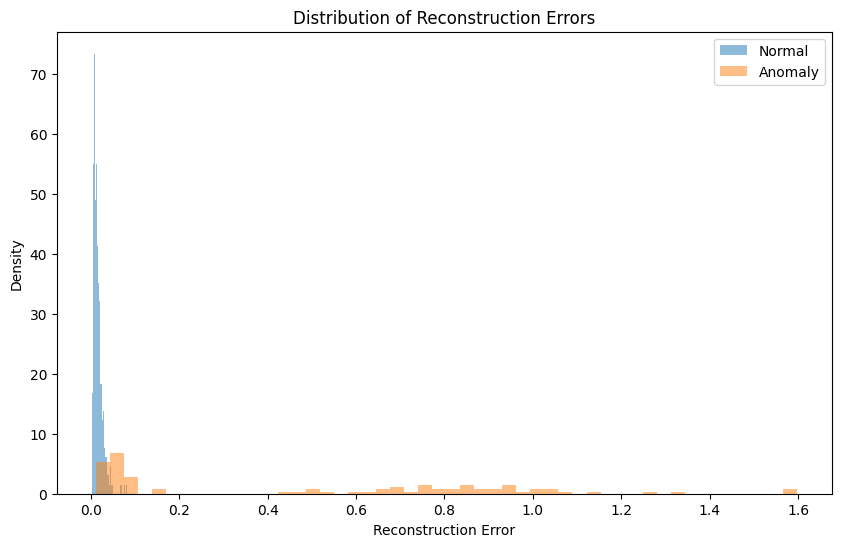

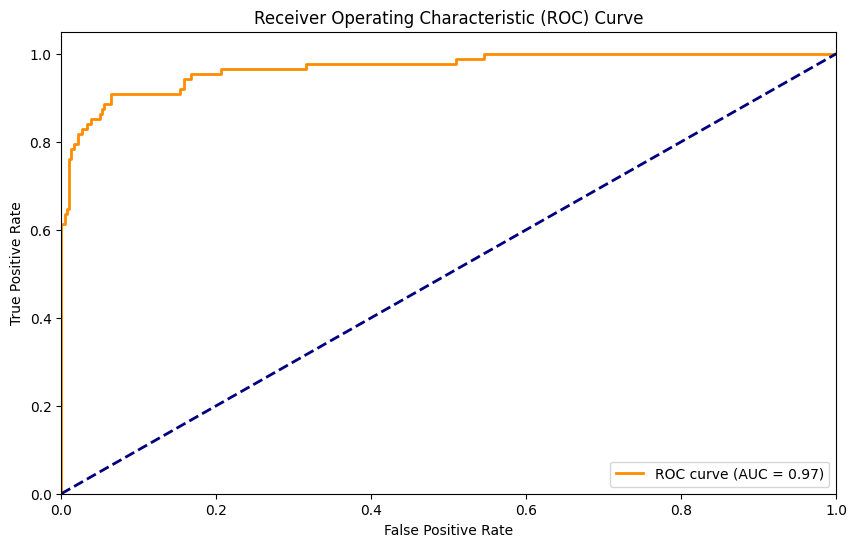

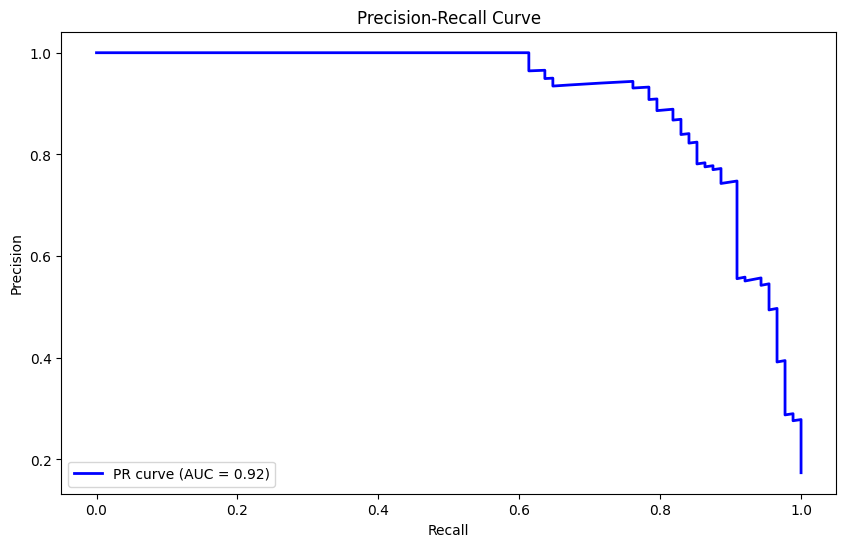

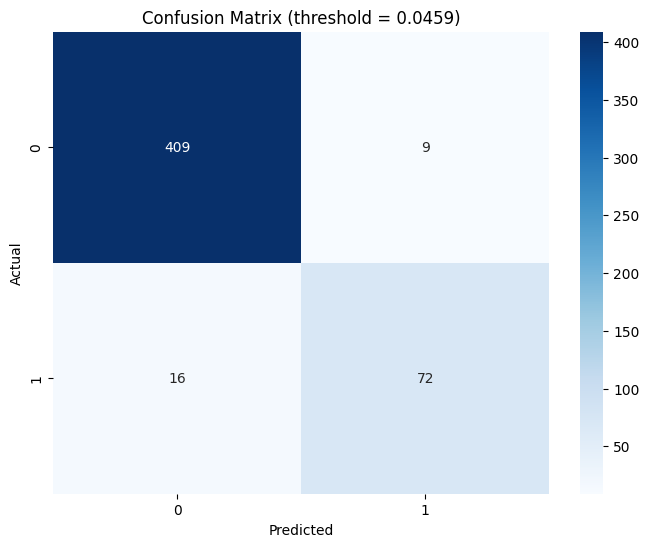


Performance Metrics:
Optimal Threshold: 0.0459
Accuracy: 0.9506
Precision: 0.8889
Recall: 0.8182
F1 Score: 0.8521
ROC AUC: 0.9682
PR AUC: 0.9186

Evaluation Results:
Optimal Threshold: 0.0459
ROC AUC: 0.9682
PR AUC: 0.9186
F1 Score: 0.8521


In [60]:
# 4. 최상의 모델 불러오기 (train_model 함수에서 저장된 모델)
model = load_trained_model(
    model=model,
    model_path=model_path,
    device=device
)

# 5. 모델 평가
results = evaluate_model(
    model=model,
    test_loader=test_loader,
    test_labels=test_labels,
    device=device
)

# 6. 결과 확인
print("\nEvaluation Results:")
print(f"Optimal Threshold: {results['optimal_threshold']:.4f}")
print(f"ROC AUC: {results['roc_auc']:.4f}")
print(f"PR AUC: {results['pr_auc']:.4f}")
print(f"F1 Score: {results['f1_score']:.4f}")